# Multisensor fusion project
- Experiment data: June 2022. Maraging Steel 300
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial ccd features, acoustic feature, thermal features
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 1: Vision acoustic segmentation

In [42]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal
import os
import math
import sys
from scipy.interpolate import griddata

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns
import librosa
import matplotlib.font_manager as font_manager

#---------------opencv------------------------
import cv2
from IPython.display import Image, display

In [2]:
import scaleogram as scg 
from glob import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import glob
import re

In [3]:
# ------------------- plotly visualizatoin----------------------------------
# from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

from glob import glob
import glob
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf
import matplotlib.font_manager as font_manager

In [4]:
## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd
import plotly.express as px
import plotly.io as pio
# import nussl
import natsort

In [5]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"

Audio_ROOT = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\LDED_audio_dataset")
             
Audio_PATH_original = os.path.join(Audio_ROOT, 'wave_file', "original")
Audio_PATH_equalized = os.path.join(Audio_ROOT, 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(Audio_ROOT, 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(Audio_ROOT, 'wave_file', "denoised",)


Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
Audio_segmented_30Hz_PATH_24 = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_30Hz_24')
Audio_segmented_30Hz_PATH = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_30Hz')
CCD_Image_30Hz_path_22 = os.path.join(Multimodal_dataset_PATH, 'Coaxial_CCD_images_30Hz')
CCD_Image_30Hz_path_24 = os.path.join(Multimodal_dataset_PATH, 'coaxial_meltpool_images_24_30Hz')

Video_path = os.path.join(Multimodal_dataset_PATH, 'Video')

IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'pre-processing')

os.makedirs(IMAGE_PATH, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [6]:
def simple_visualization(sound, sr=44100, alpha = 1, fig_size = (10,2)):
    fig, axs = plt.subplots(1, 1, tight_layout = True, figsize=fig_size) #constrained_layout=True,

    librosa.display.waveplot(sound, sr=sr, alpha=alpha, label = 'original signal')
    axs.set_xlabel('Time [sec]', fontsize = 14)
    axs.set_ylabel('Amplitute', fontsize = 14)
    # axs.set_ylim([-0.28, 0.28])
    # axs.set_yticks([-0.25, 0, 0.25])

    # fig.suptitle("Time-domain visualisation", fontsize = 16)

In [7]:
sys.path.insert(0, 'utils')

import visualization

## Segment MP4 video file

- __FFmpeg__: to extract the audio stream from the input MP4 file (__not recommended__) --> result in corrupted file
- __moviepy__: extract audio from mp4 video stream.
- __OpenCV__ to extract the video frames
- __iterates over each frame__ and uses FFmpeg to extract the corresponding audio segment; OpenCV to extract the corresponding video segment
- The audio and image segments are then saved to their respective output folders with the desired names.

In [17]:
import os
import librosa
import librosa.display
import cv2
import subprocess

sample_index = 24
# Define input video file path
raw_video_file = os.path.join(Video_path, str(sample_index), 'raw',  f'{sample_index}-raw.mp4')
equalized_video_file = os.path.join(Video_path, str(sample_index), 'equalized', f'{sample_index}-equalized.mp4') 
bandpassed_video_file = os.path.join(Video_path, str(sample_index), 'bandpassed', f'{sample_index}-bandpassed.mp4') 
denoised_video_file = os.path.join(Video_path, str(sample_index), 'denoised', f'{sample_index}-denoised.mp4') 

# Output folders
raw_audio_output_folder = os.path.join(Video_path,  'segmented', 'raw_audio')
equalized_audio_output_folder = os.path.join(Video_path,  'segmented','equalized_audio')
bandpassed_audio_output_folder = os.path.join(Video_path, 'segmented', 'bandpassed_audio')
denoised_audio_output_folder = os.path.join(Video_path, 'segmented', 'denoised_audio')
image_output_folder = os.path.join(Video_path, 'segmented', 'images')


# Create output folders if they don't exist
if not os.path.exists(image_output_folder):
    os.makedirs(image_output_folder)
if not os.path.exists(denoised_audio_output_folder):
    os.makedirs(denoised_audio_output_folder)
if not os.path.exists(raw_audio_output_folder):
    os.makedirs(raw_audio_output_folder)
if not os.path.exists(equalized_audio_output_folder):
    os.makedirs(equalized_audio_output_folder)
if not os.path.exists(bandpassed_audio_output_folder):
    os.makedirs(bandpassed_audio_output_folder)

In [10]:
from moviepy.editor import VideoFileClip


# Extract the audio
audio = VideoFileClip(denoised_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/denoised.wav')

# Extract the audio
audio = VideoFileClip(raw_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/raw.wav')

# Extract the audio
audio = VideoFileClip(equalized_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/equalized.wav')

# Extract the audio
audio = VideoFileClip(bandpassed_video_file).audio
# Save the audio to a file
audio.write_audiofile(f'{Video_path}/{sample_index}/audio/bandpass.wav')

MoviePy - Writing audio in C:\Users\Asus\OneDrive_Chen1470\OneDrive - Nanyang Technological University\Dataset\Multimodal_AM_monitoring\LDED_Acoustic_Visual_Dataset\Video/24/audio/denoised.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\Asus\OneDrive_Chen1470\OneDrive - Nanyang Technological University\Dataset\Multimodal_AM_monitoring\LDED_Acoustic_Visual_Dataset\Video/24/audio/raw.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\Asus\OneDrive_Chen1470\OneDrive - Nanyang Technological University\Dataset\Multimodal_AM_monitoring\LDED_Acoustic_Visual_Dataset\Video/24/audio/equalized.wav


MoviePy - Done.
MoviePy - Writing audio in C:\Users\Asus\OneDrive_Chen1470\OneDrive - Nanyang Technological University\Dataset\Multimodal_AM_monitoring\LDED_Acoustic_Visual_Dataset\Video/24/audio/bandpass.wav


MoviePy - Done.


In [13]:
# Load the audio and calculate the segment length in samples
y_raw, sr = librosa.load(f'{Video_path}/{sample_index}/audio/raw.wav', sr=None)
y_equalized, sr = librosa.load(f'{Video_path}/{sample_index}/audio/equalized.wav', sr=None)
y_bandpassed, sr = librosa.load(f'{Video_path}/{sample_index}/audio/bandpass.wav', sr=None)
y_denoised, sr = librosa.load(f'{Video_path}/{sample_index}/audio/denoised.wav', sr=None)

segment_duration = 0.1  # 0.1 seconds
segment_length = int(segment_duration * sr)
print ("the segmentation length is: " + str(segment_length))
print ("the segmentation length in second is: " + str(segment_length/44100))
print ("total duration of audio signal: " + str(len(y_raw)/44100))
print ("total number of images: " + str((len(y_raw) - segment_length)/segment_length))
print ("length of each audio file are: " + str(len(y_denoised)/44100) + "; " + str(len(y_raw)/44100) + "; " + str(len(y_equalized)/44100) 
       + "; " + str(len(y_bandpassed)/44100))

the segmentation length is: 4410
the segmentation length in second is: 0.1
total duration of audio signal: 223.04
total number of images: 2229.4
length of each audio file are: 452.27; 223.04; 452.27; 452.27


In [18]:
# Initialize a counter for audio and image file names
counter = 1
raw_seg = []
equalized_seg = []
bandpassed_seg = []
denoised_seg = []

# Iterate over the audio and save each segment
for i in range(0, len(y_denoised) - segment_length, segment_length):
    # print (i)
    # Extract the audio segment
    segment_denoised = y_denoised[i:i+segment_length]
    segment_raw = y_raw[i:i+segment_length]
    segment_equalized = y_equalized[i:i+segment_length]
    segment_bandpassed = y_bandpassed[i:i+segment_length]
    
    denoised_seg.append(segment_denoised)
    raw_seg.append(segment_raw)
    equalized_seg.append(segment_equalized)
    bandpassed_seg.append(segment_bandpassed)
    
    sf.write(f'{raw_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_raw, samplerate = sr)
    sf.write(f'{equalized_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_equalized, samplerate = sr)
    sf.write(f'{bandpassed_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_bandpassed, samplerate = sr)
    sf.write(f'{denoised_audio_output_folder}/sample_{sample_index}_{counter}.wav', segment_denoised, samplerate = sr)

    # Use OpenCV to extract the video segment
    cap = cv2.VideoCapture(denoised_video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(i / sr * fps))
    ret, frame = cap.read()
    cv2.imwrite(f'{image_output_folder}/sample_{sample_index}_{counter}.jpg', frame)
    cap.release()
    
    # Increment the counter
    counter += 1

# # Handle the last segment (which may be shorter than segment_length)
# last_segment = y[len(y) - segment_length:]
# exp_22_denoised_seg.append(last_segment)
# sf.write(f'{audio_output_folder}/sample_22_{counter}.wav', last_segment, samplerate = sr)

# cap = cv2.VideoCapture(input_file)
# fps = cap.get(cv2.CAP_PROP_FPS)
# cap.set(cv2.CAP_PROP_POS_FRAMES, int((len(y)-len(last_segment)) / sr * fps))
# ret, frame = cap.read()
# cv2.imwrite(f'{image_output_folder}/{counter}.jpg', frame)

cap.release()

KeyboardInterrupt: 

## Inspection

### Sample 24

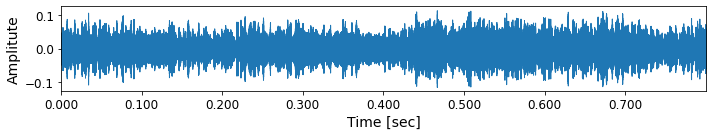

In [50]:
test = []
for seg in exp_22_denoised_seg[135:143]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)
simple_visualization(test)

In [51]:
ipd.Audio(test, rate=sr)

138


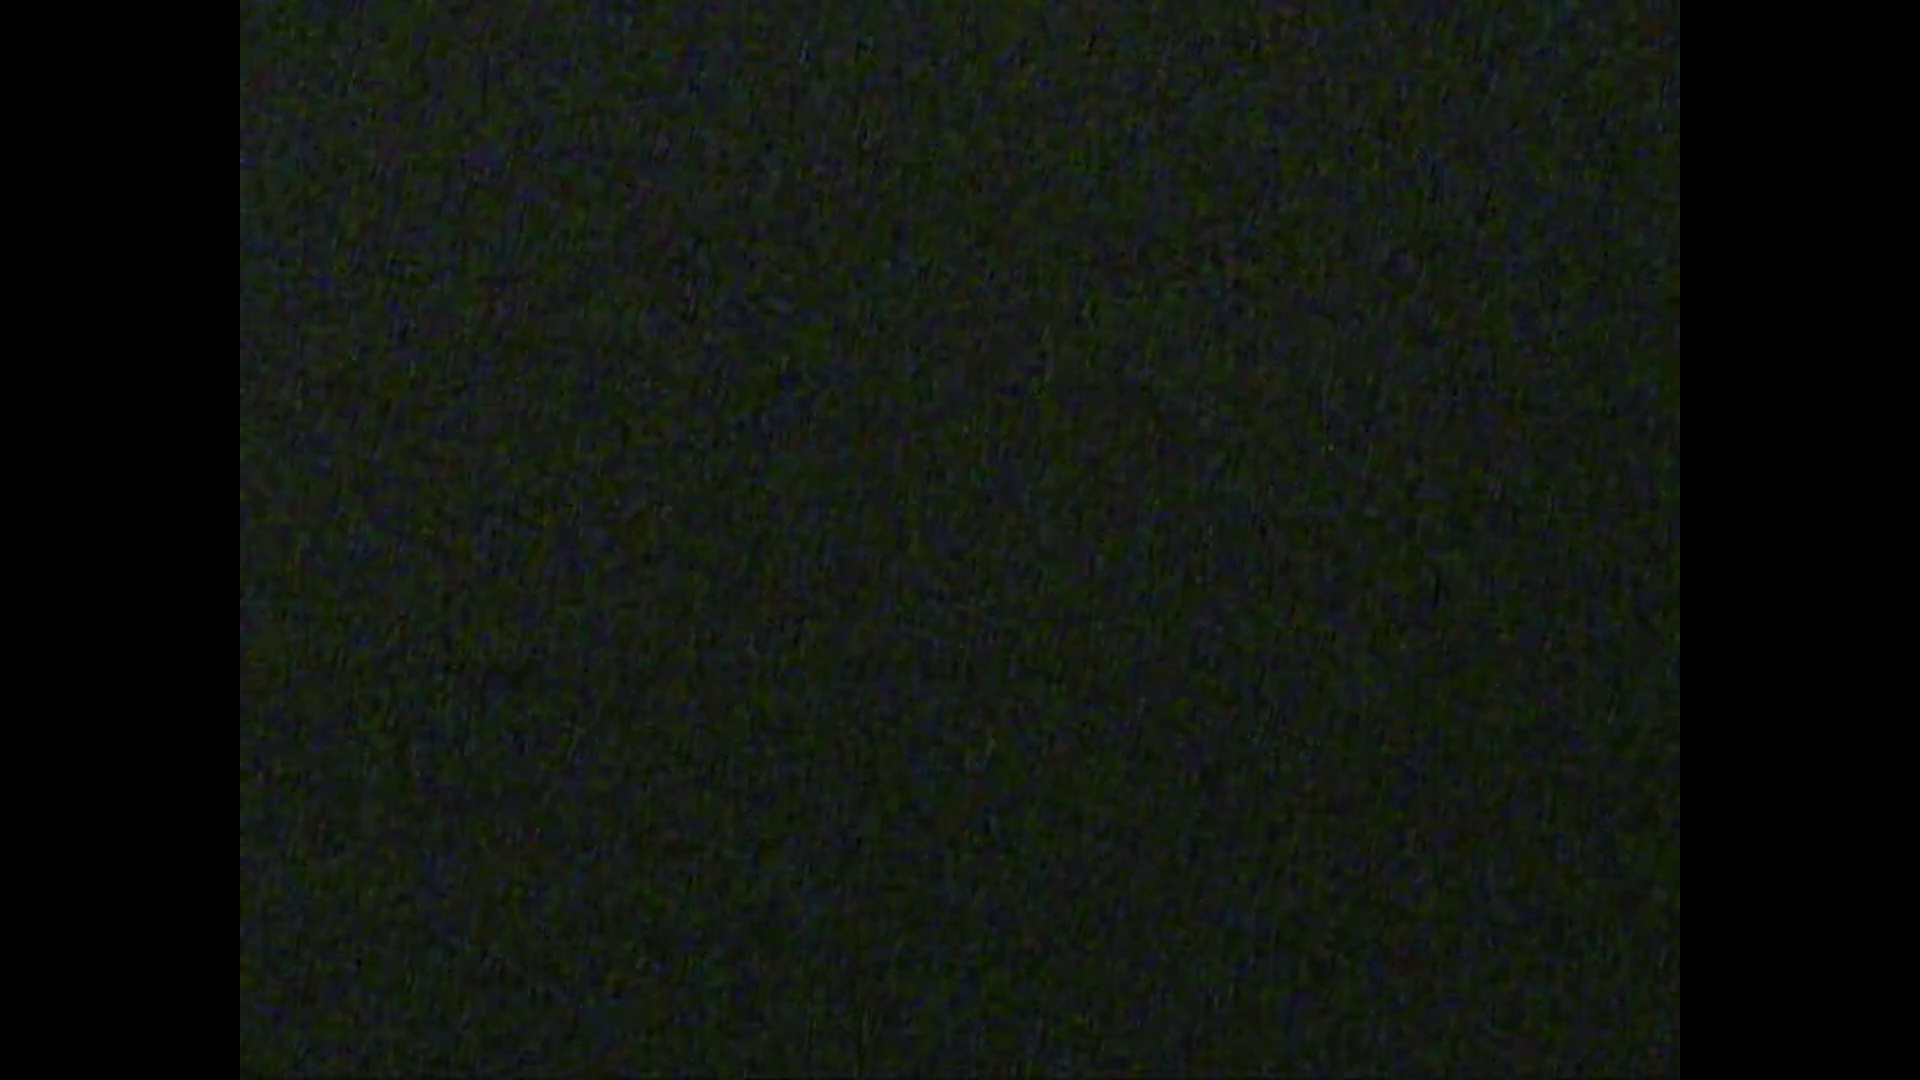

139


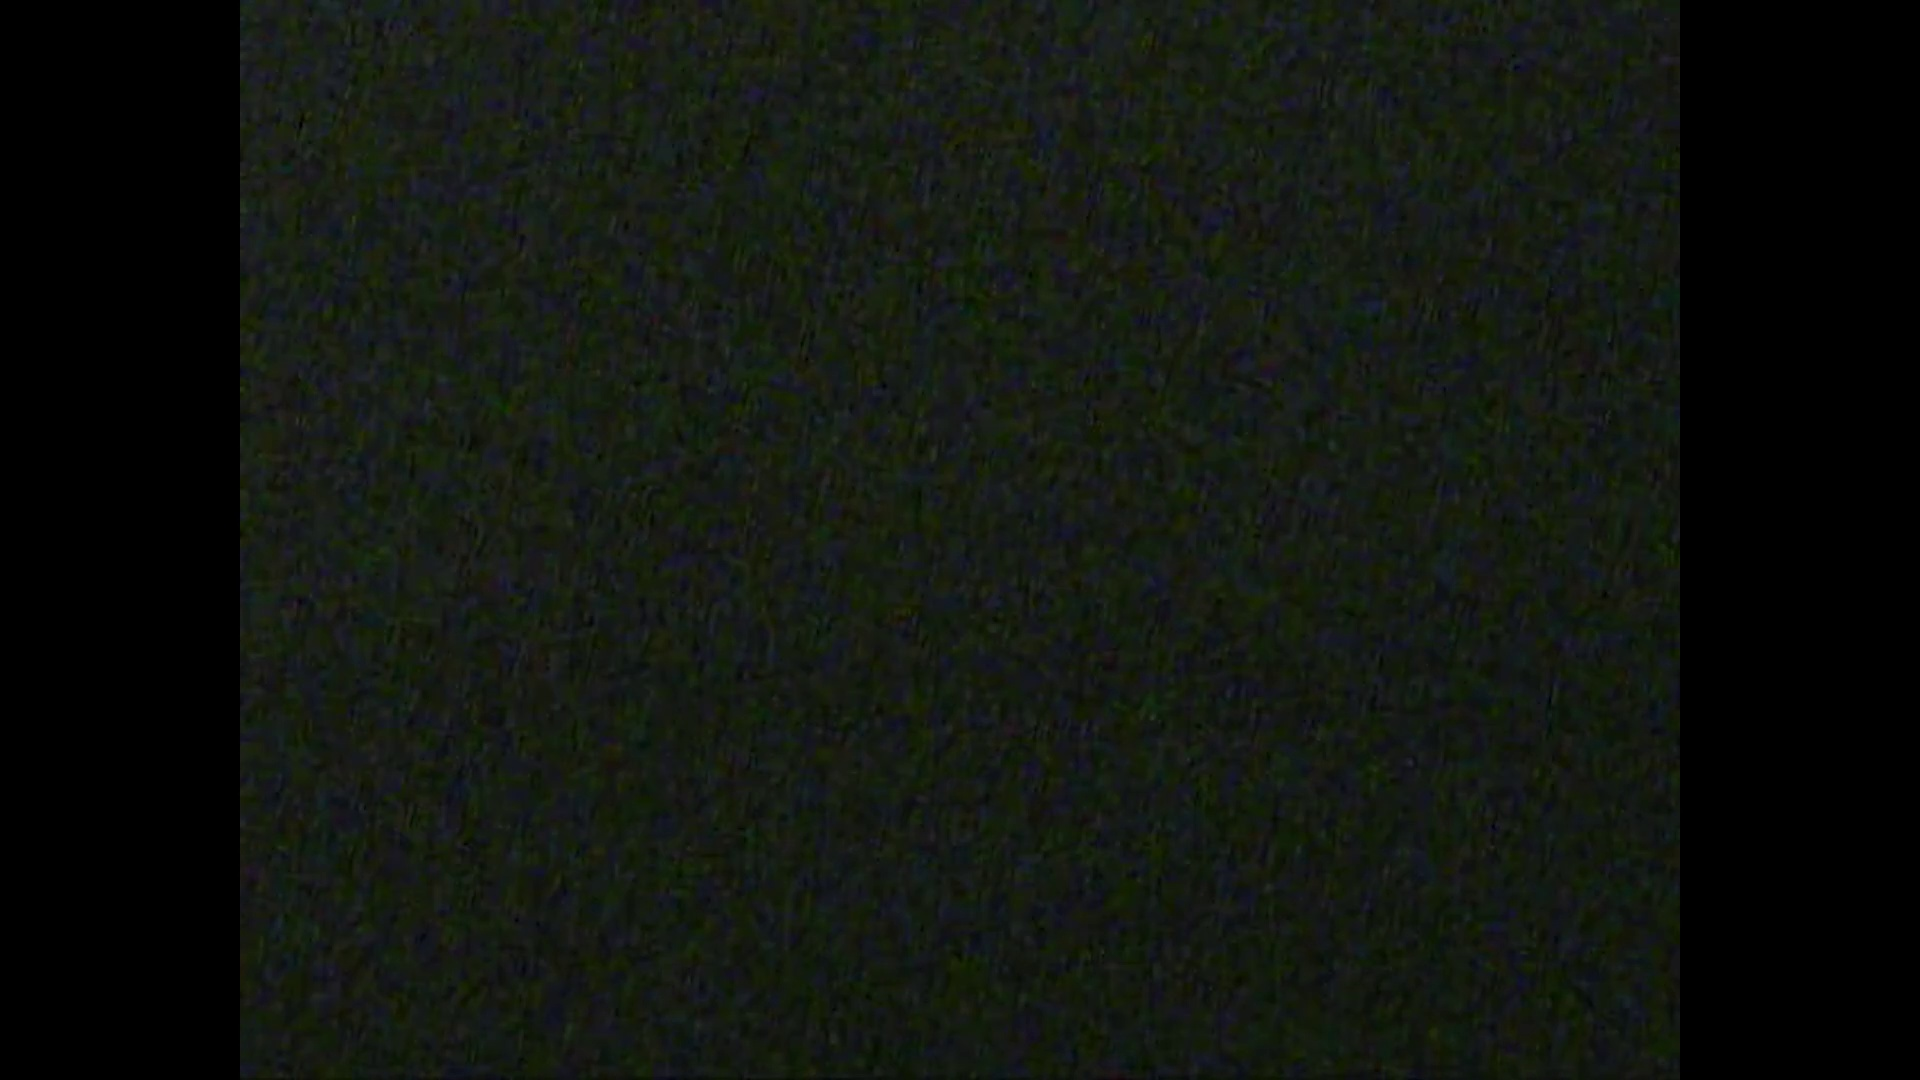

140


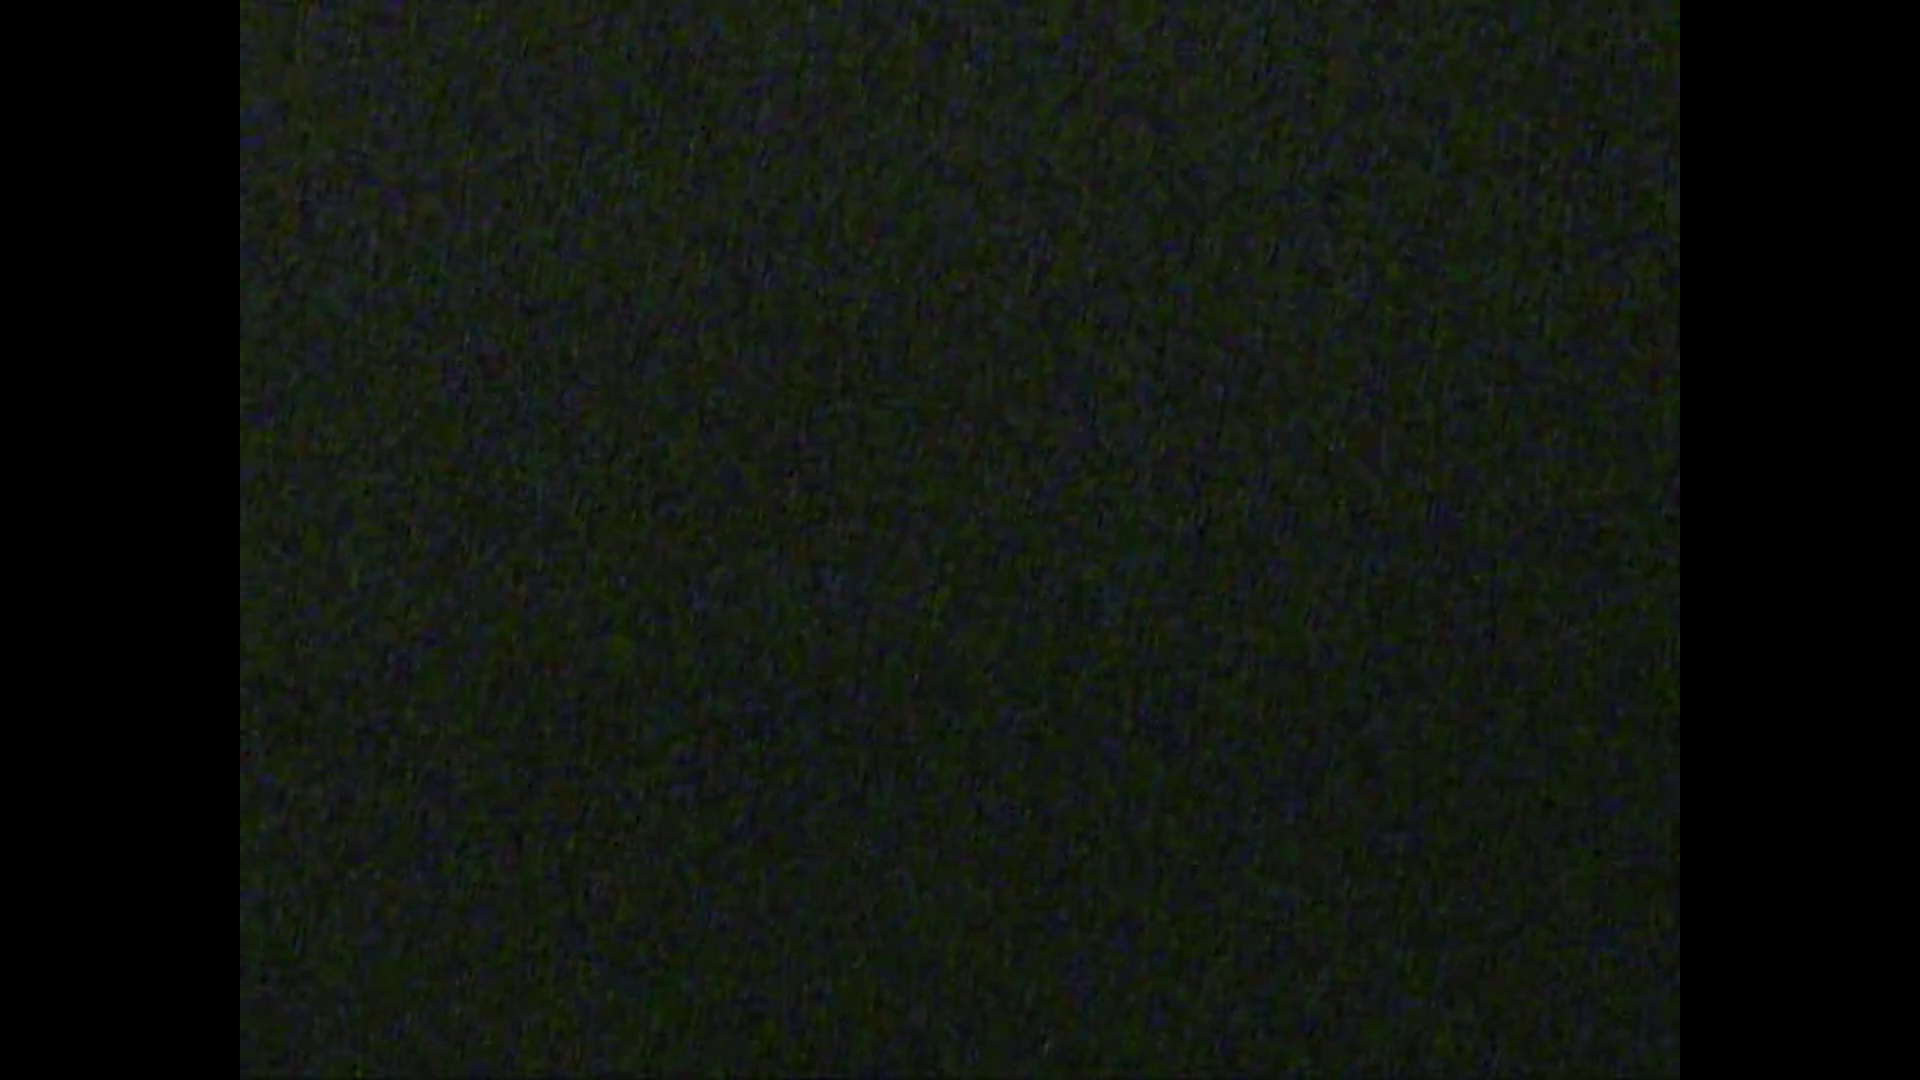

141


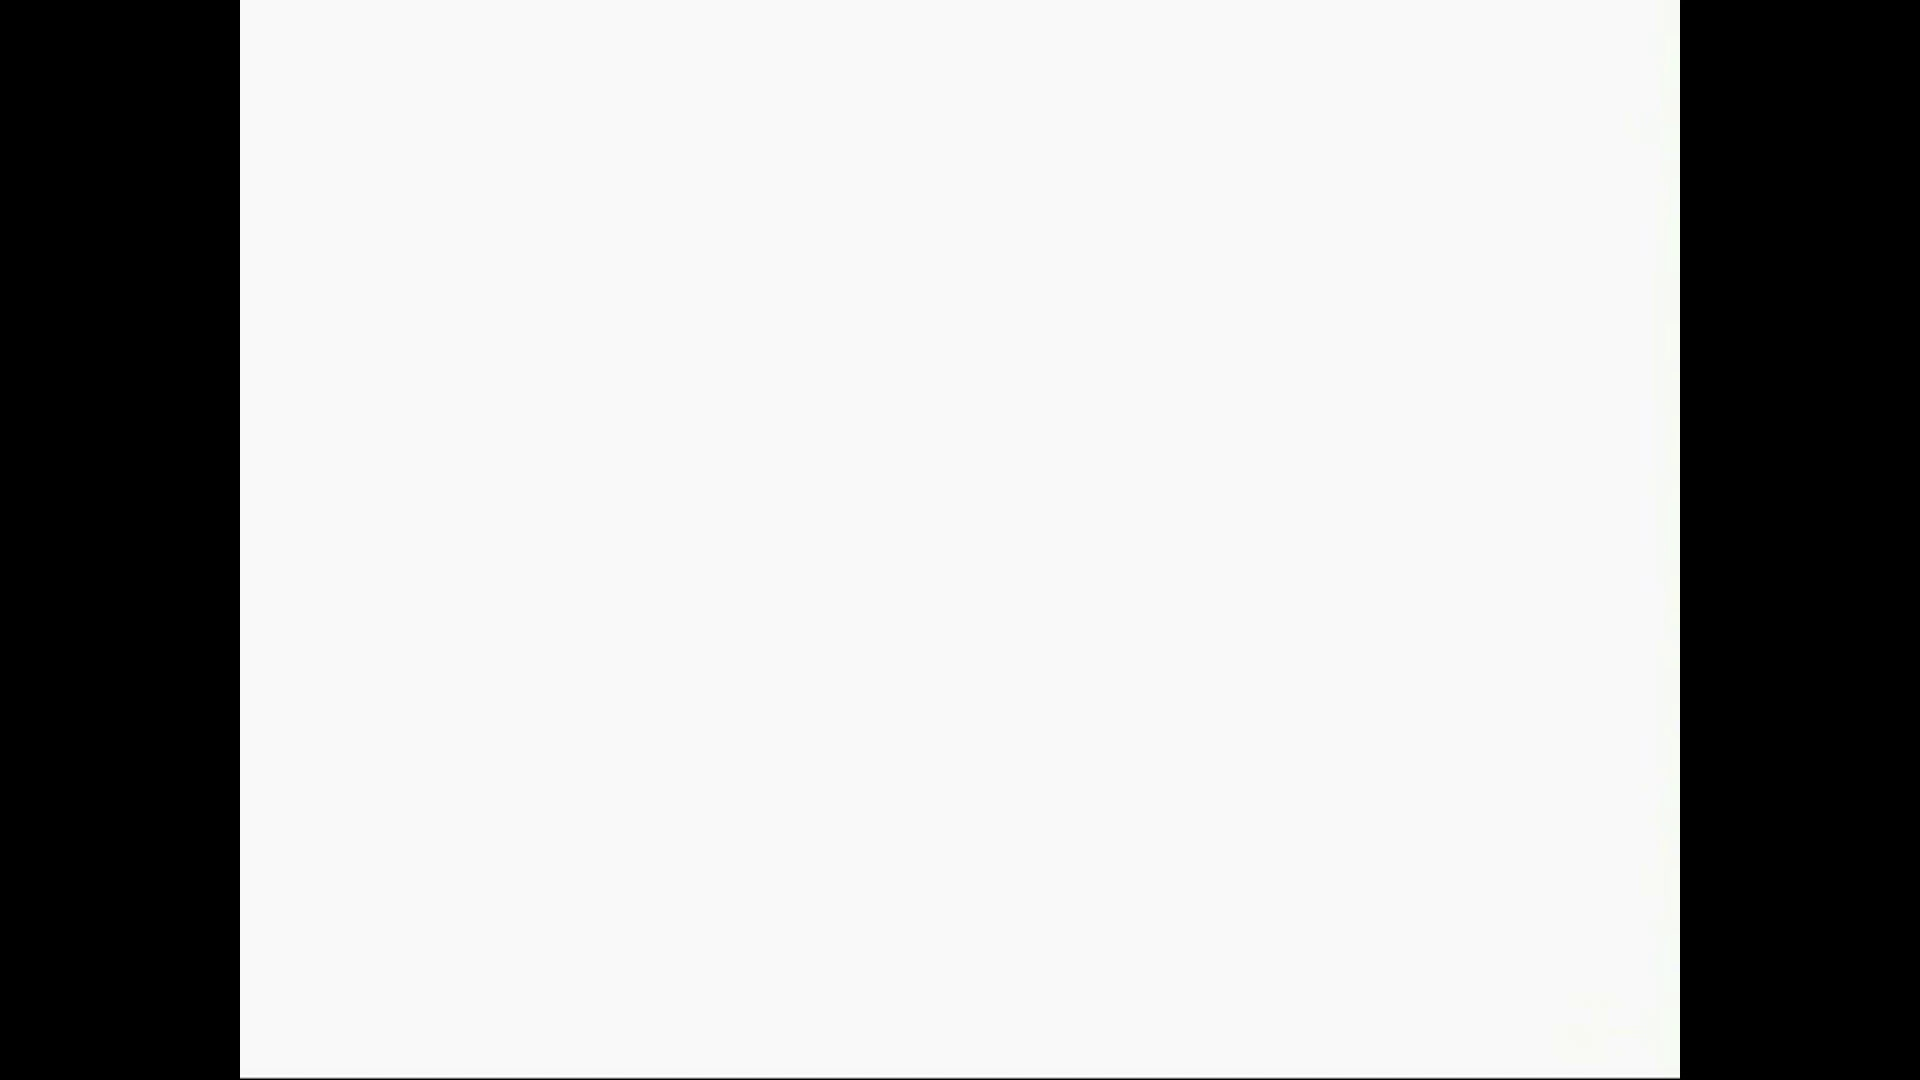

142


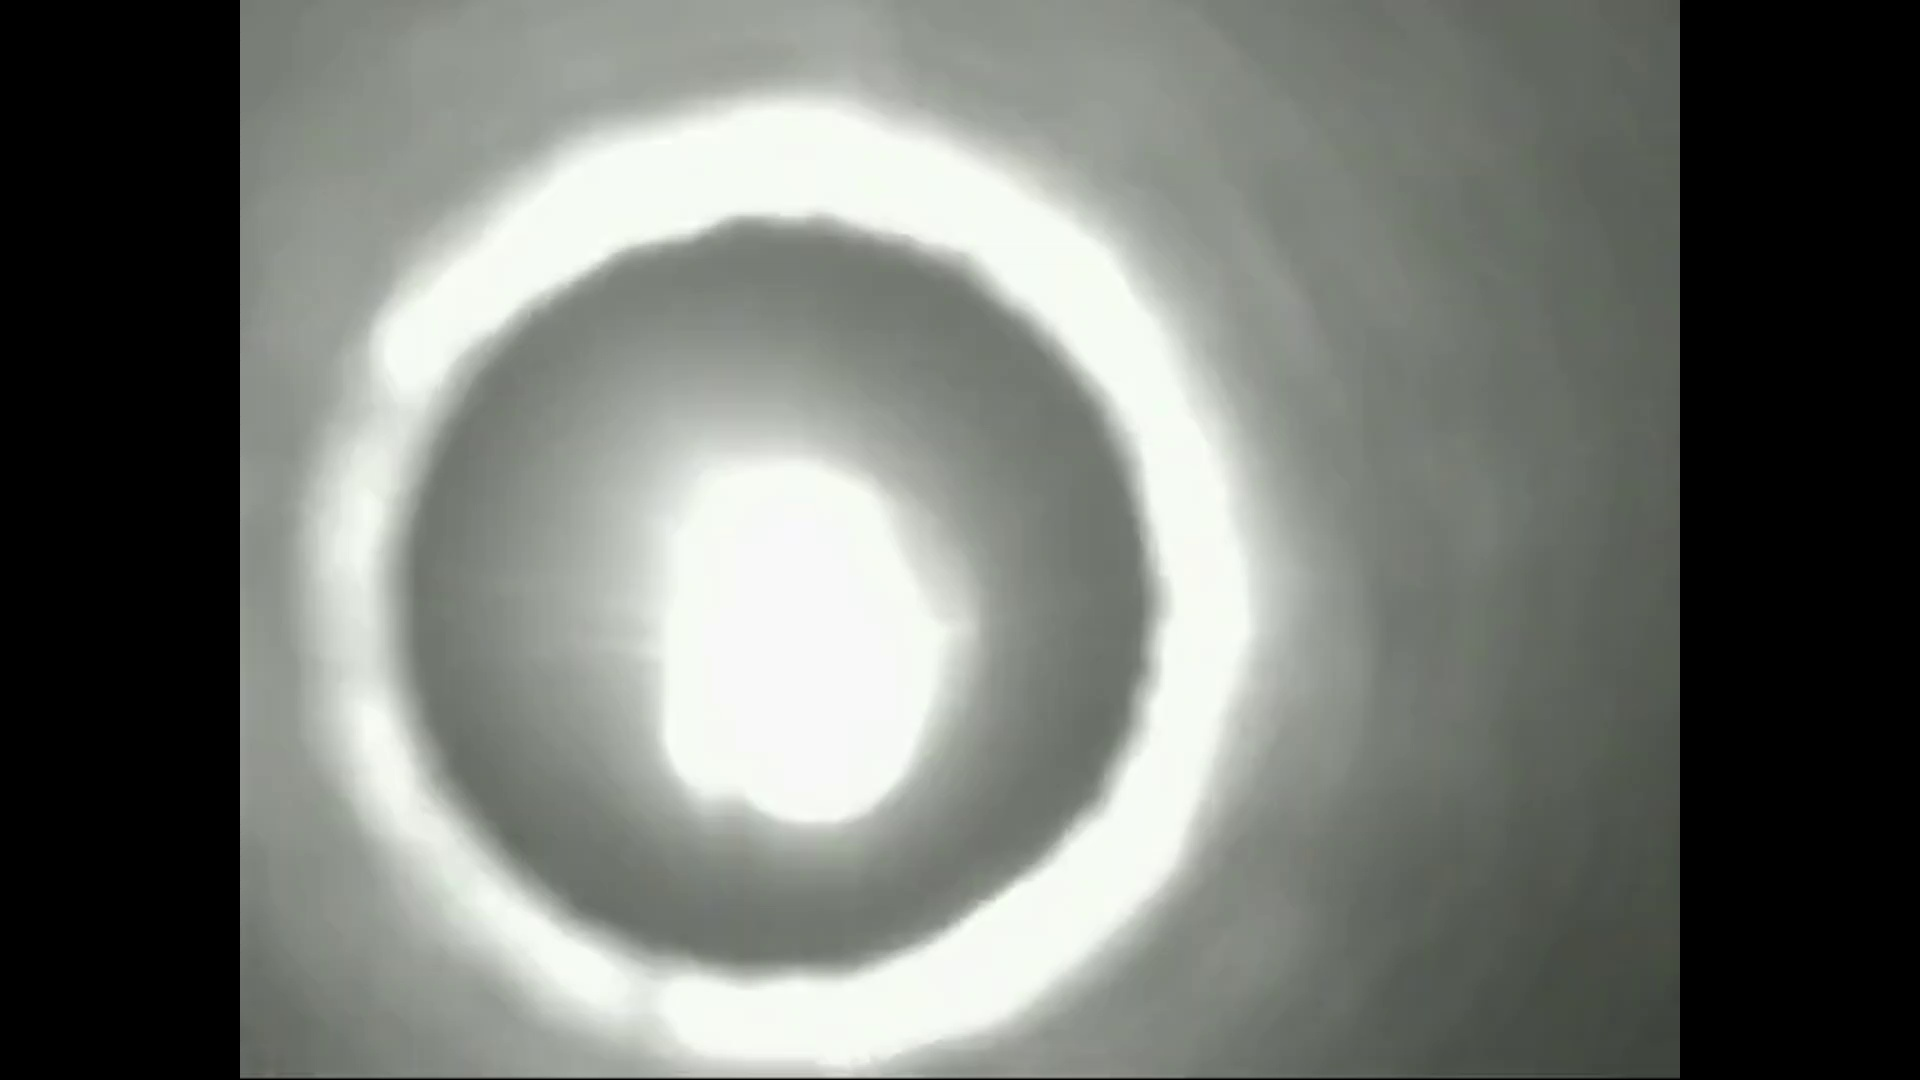

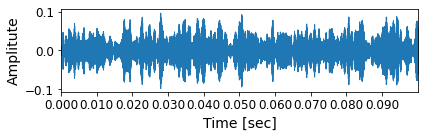

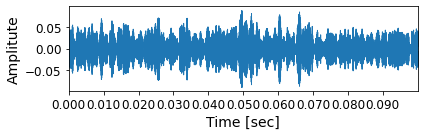

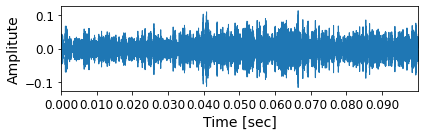

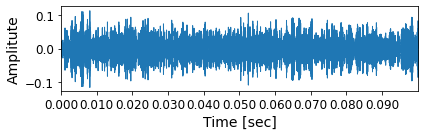

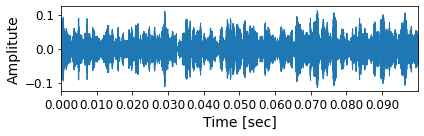

In [47]:
for i in range(138,143):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(denoised_audio_output_folder, f'sample_{sample_index}_{i}.wav'), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_{sample_index}_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (6,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

### Sample 22

In [148]:
test = []
for seg in exp_22_raw_seg[100:125]:
    seg = list(seg)
    test.extend(seg)
test = np.asarray(test)

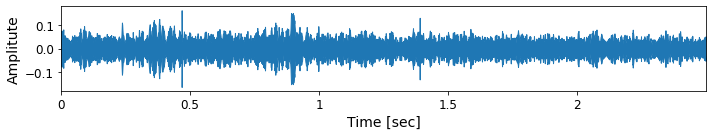

In [149]:
simple_visualization(test)

In [150]:
ipd.Audio(test, rate=sr)

In [40]:
for i in range(108,115):
    print (i)
    segment_audio, sr = librosa.load(os.path.join(raw_audio_output_folder, f'sample_22_{i}_raw' +".wav"), sr=None)
    segment_image = os.path.join(image_output_folder, f'sample_22_{i}'+".jpg")
    simple_visualization(segment_audio, fig_size = (12,2)) #int(44100*833)
    # visualization.plot_mfcc(segment_audio, 44100, str(i))
    display(Image(segment_image, width=100))

108


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset\\Video\\segmented\\raw_audio\\sample_22_108_raw.wav'

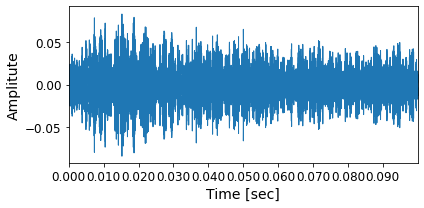

In [88]:
simple_visualization(segment_audio, fig_size = (6,3)) #int(44100*833)

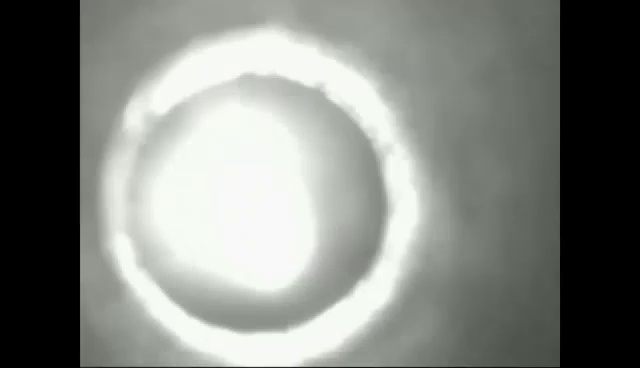

In [89]:
display(Image(segment_image, width=100))